In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
df=pd.read_csv('/kaggle/input/nf-uq-nids-v2-sample/NF-UQ-NIDS-V2-Sample.csv')
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset,Attack_Class
0,192.168.100.148,65389,192.168.100.7,80,6,7.0,420,3,0,0,...,35840,140,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2,DoS/DDoS
1,192.168.100.148,11154,192.168.100.5,80,6,7.0,280,2,40,1,...,0,0,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2,DoS/DDoS
2,192.168.1.31,42062,192.168.1.79,1041,6,0.0,44,1,40,1,...,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2,Benign
3,192.168.1.34,46849,192.168.1.79,9110,6,0.0,44,1,40,1,...,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2,Benign
4,192.168.1.30,50360,192.168.1.152,1084,6,0.0,44,1,40,1,...,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2,Benign


In [3]:
X=df.drop(['Attack','Dataset','Attack_Class','Label'],axis=1)
y=df['Attack_Class']

In [4]:
X.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
0,192.168.100.148,65389,192.168.100.7,80,6,7.0,420,3,0,0,...,0,0,512,0,35840,140,0,0,0,0.0
1,192.168.100.148,11154,192.168.100.5,80,6,7.0,280,2,40,1,...,0,0,512,0,0,0,0,0,0,0.0
2,192.168.1.31,42062,192.168.1.79,1041,6,0.0,44,1,40,1,...,0,0,1024,0,0,0,0,0,0,0.0
3,192.168.1.34,46849,192.168.1.79,9110,6,0.0,44,1,40,1,...,0,0,1024,0,0,0,0,0,0,0.0
4,192.168.1.30,50360,192.168.1.152,1084,6,0.0,44,1,40,1,...,0,0,1024,0,0,0,0,0,0,0.0


In [5]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

#ip addresses are in format xxx.xxx.xxx.xxx which is not compatible with the models
srcaddr= LE.fit_transform(X['IPV4_SRC_ADDR'])
X['IPV4_SRC_ADDR'] = pd.Series(srcaddr)
dstaddr= LE.fit_transform(X['IPV4_DST_ADDR'])
X['IPV4_DST_ADDR'] = pd.Series(dstaddr)
del srcaddr,dstaddr # Delete variables no longer needed

In [6]:
LE = LabelEncoder()
multilbl = LE.fit_transform(y)
y = pd.Series(multilbl)
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

X_object = X.select_dtypes("object")
X_int = X.select_dtypes(exclude = "object")

X_columns = X_int.columns #this stores column names 

imputer.fit(X_int)
X_int = imputer.transform(X_int)
X_int = pd.DataFrame(X_int)
X_int.columns = X_columns #corrects column name

X_object = X_object.fillna("unknown")
X = X_object.join(X_int)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# store the columns
cols = X.columns

# transform the data
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns = cols)
 
# Access the original classes
classes = LE.classes_


# Print the mapping
for i, cls in enumerate(classes):

    print(f"{i}: {cls}")

0: Benign
1: Botnet
2: Brute Force
3: DoS/DDoS
4: MITM
5: Malware
6: Password
7: Phishing
8: SQL Injection
9: XSS
10: Zero Day Exploit


In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
model.fit(X_scaled, y)
importances = model.feature_importances_
importances

array([7.41066386e-02, 1.61221811e-02, 1.17673833e-01, 4.44028184e-02,
       2.48062437e-03, 5.50645495e-02, 6.36717268e-03, 1.93648553e-02,
       2.41439819e-02, 3.47065627e-02, 1.37543682e-02, 1.54256512e-02,
       6.91228785e-03, 8.79918853e-02, 1.00715016e-01, 4.60140596e-03,
       2.75962080e-02, 2.26008919e-02, 3.74712589e-02, 1.76034663e-02,
       3.66685820e-02, 3.14737742e-02, 2.72102427e-08, 2.34597837e-08,
       7.85617735e-04, 3.47692383e-04, 6.35372804e-04, 6.26668282e-04,
       3.20278119e-02, 5.15650996e-02, 1.83250413e-02, 6.73655419e-03,
       2.07223316e-03, 1.18410586e-03, 2.36676252e-03, 5.03527578e-02,
       2.15706871e-02, 6.63555241e-04, 4.70733000e-04, 5.29946406e-03,
       7.18823354e-03, 1.68278645e-04, 3.65266520e-04])

In [8]:
feature_imp = pd.DataFrame({'Importance':model.feature_importances_,'feature':X.columns})
feature_imp = feature_imp.sort_values('Importance',ascending=False).set_index('feature')

In [9]:
feature_imp

,Importance
feature,
IPV4_DST_ADDR,1.176738e-01
DURATION_IN,1.007150e-01
FLOW_DURATION_MILLISECONDS,8.799189e-02
IPV4_SRC_ADDR,7.410664e-02
L7_PROTO,5.506455e-02
DST_TO_SRC_AVG_THROUGHPUT,5.156510e-02
TCP_WIN_MAX_IN,5.035276e-02
L4_DST_PORT,4.440282e-02
LONGEST_FLOW_PKT,3.747126e-02


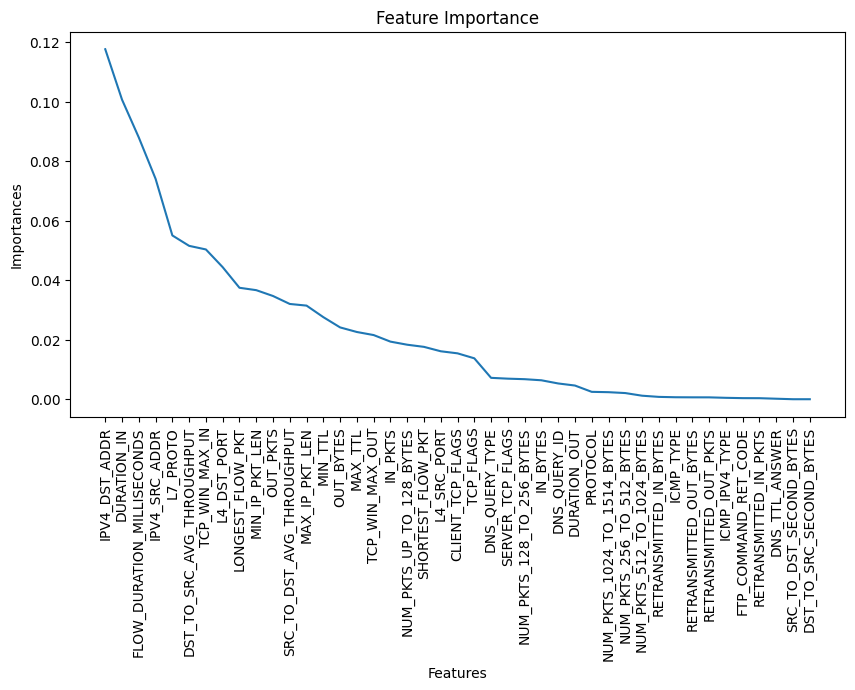

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize = (10, 5))
plt.title("Feature Importance", fontname="Times New Roman")
plt.ylabel("Importances")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.plot(feature_imp)
plt.savefig('feature_importance.jpg', bbox_inches='tight' , dpi=900)

In [11]:
from sklearn.feature_selection import RFE
estimator = RandomForestClassifier()
selector = RFE(estimator,n_features_to_select=30)
selector.fit(X_scaled, y)

X_scaled_2 = selector.transform(X_scaled)


In [12]:
selector.get_feature_names_out(input_features=None)

array(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT',
       'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT',
       'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_AVG_THROUGHPUT',
       'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES',
       'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'DNS_QUERY_ID',
       'DNS_QUERY_TYPE'], dtype=object)

In [13]:
selector.get_support(indices=True)

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 28, 29, 30, 31, 34, 35, 36, 39, 40])

In [14]:
selector.get_params(deep=True)

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'importance_getter': 'auto',
 'n_features_to_select': 30,
 'step': 1,
 'verbose': 0}